# Discrete Optimization

Typically when we optimize deep learning systems (or more broadly most machine learning systems) we use continous parameters. This is because the suite of techniques we use rely on gradient descent which approximate the derivative of our variables and optimize in the direction which lowers the loss value. For continous valued parameters this isn't an issue, as we can simply approximate the gradient using SGD. This also holds for values which are _approximately_ continous (floating point numbers after all are still discrete deep down).

However, there are cases when the nature of a problem requires the use of discrete parameters. For example, consider the case of turning off or on pixels in a sensor. In this case there are only two states: **off** or **on**. When working with physical system optimization these kinds of discrete parameters come up frequently.

There are many examples of discrete parameter optimization, including:
1. Pixel selection
2. Frequency selection
3. Selection from a set

As well as many others. Some of you may find these concepts very useful in your projects...

## Fallacies of Discrete Optimization

While discrete optimization is a powerful tool, especially in the context of physical optimization, students can often set themselves up for failure. The most common mistake is to identify a discrete optimization task which on it's own has an obvious solution.

For example, think of pixel selection, where we aim to determine which pixels of our sensor will be active or not. Under no constraints the obvious solution is that all of them should be active, as more information is always better! This of course applies as well to frequency selection, as well as selection from a set. 

To avoid this type of error it is important to contrain your system to ensure that your optimization represents something meaningful. Looking back at our pixel selection task, while the unconstrained version has an obvious solution, the constrained version is more interesting. If you can only have 10% of the pixels, which 10% should they be?

# Discrete Optimization Strategies

To facilitate the optimization of discrete parameters we need to model them in a continous fashion. Today we will cover two ways of doing this, and in the exercises you will implement both.

## Simulated Annealing
The first approach is called _simulated annealing_, and it takes what we call a "soft to hard" method. We start with a continous model of our parameter (which is not physically realizable), and slowly "hardens" the parameter values, until they are very close to the discrete parameters. 

The simplest example is binarization, forcing a value to be either zero or one. We can model our continous parameter as $\theta$, and create some function $f(\theta, t)$ where $t$ is a "timestep" variable. Our goal is then, over time, to move from a continous $f$, to a discrete $f$. For binarization this is quite simple, we can start with the standard _sigmoid_ function:

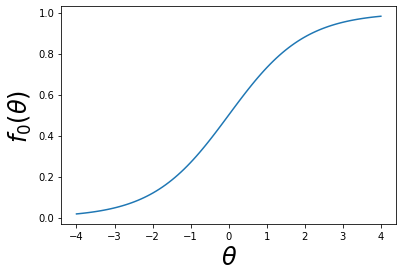




Then at $t=\infty$ we would want the function to be discrete:

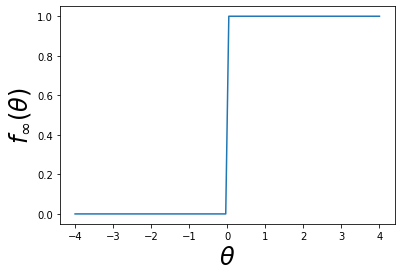

In this example we can control the "hardness" of the function with a simple parameter, which we term $\psi$, with $f(\theta, t) = sigmoid(\psi^t \theta)$. Assuming  $\psi \geq 1$, then as $t \rightarrow \infty$, $f(\theta, t)$ becomes discrete.

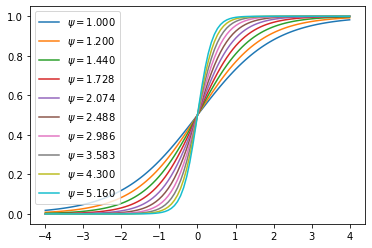

Of course this is just one way of achieving this "soft to hard" transition, and how you schedule $\psi$ is dependent on your application. 

Also, in reality we need to add a small amount of noise to the input value, otherwise it may converge to zero.

## Probalistic Optimization

Another method to represent a discrete parameter with a continous one is to do so probabilistically. The idea here is to parameterize a discrete probability distribution, then sample that distribution to get the discrete outcome you want. A wrinkle here is that the sampling process itself is discrete (i.e. non-differentiable), however we can actually approximate this discrete distribution with a continous one.

This kind of "continuous relaxation" was first demonstrated in two papers from ICLR 2017:
- [The Concrete Distribution: A Continuous Relaxation of Discrete Random Variables
](https://arxiv.org/abs/1611.00712)
- [Categorical Reparameterization with Gumbel-Softmax
](https://arxiv.org/abs/1611.01144)


In a typical categorical distribution you would have a fixed number of outcomes $[y_1, y_2, \dots y_n]$, and a set of probabilities of each outcome occuring $[p_1, p_2, \dots p_n]$. This setup should be familiar from the typical classification problem where we use categorical cross-entropy loss. If, for example, we have three outcomes we could visually represent the probability of each outcome on a triangle:

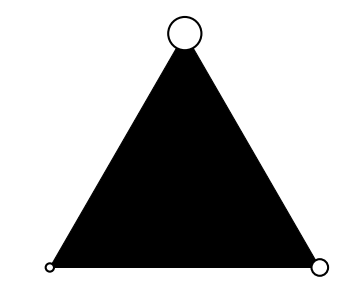



Where the white areas represent the sampling probability ($[p_1, p_2, p_3]$), and the vertices represent the three outcomes ($[y_1, y_2, y_3]$). As we can see, each outcome occurs independently, there is no outcome which is partially $y_1$ and $y_2$, which is by definition the way a categorical distribution should behave. This lack of mixing is also what makes the gradient impossible to derive.

However, we could also consider the case in which there was a small amount of mixing, perhaps in proportion to some mixing parameter $\lambda$. In that case we would instead expect outcomes to still be clustered around the vertices, but now not purely be a single outcome. 

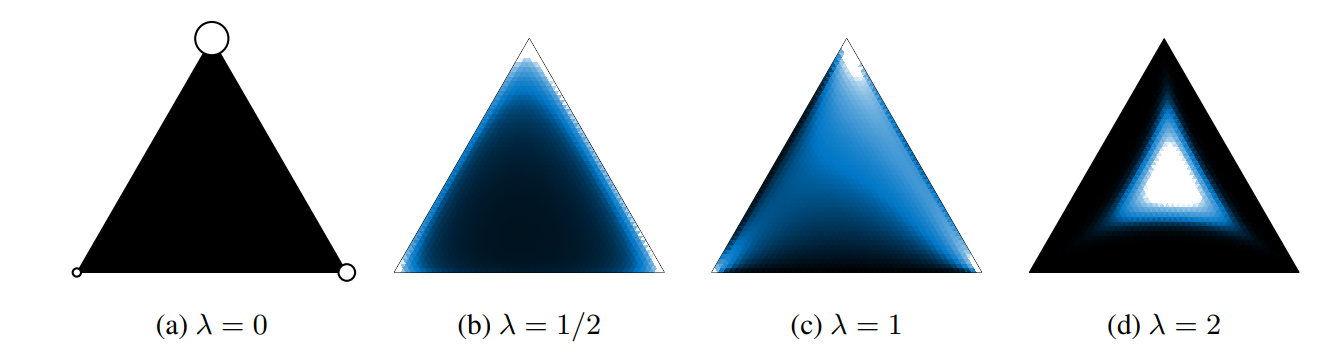

Formally, we define $\lambda$ as our _temperature_ parameter. With $\lambda=0$ we get a normal categorical distribution, and as $\lambda$ grows we slowly get a multi-variate gaussian (see $\lambda=2$ case).

You can think of this as being similar to the prior discrete optimization technique, in that we can control the "hardness" of our sampling through $\lambda$, and we can turn $\lambda$ down (or alternatively allow $\phi = \frac{1}{\lambda}$ and gradually tune up $\phi$). 

However, there are actually two distinctions between the probabalistic strategy and annealing strategy:
1. Even with a moderate $\lambda$ you incur an "uncertainty" penalty, which should incentivize low entropy parameterizations (probabilities in which one outcome dominates)
2. There is a "trick" which allows you to always use discrete outcomes but take the gradients of the continuous distribution. We will get into this momentarily

# Example: Selection from a set

As an example we are going to go through a simple example of discrete optimization using both methods, and two variants of the probabalistic method. We will be doing a "Selection from a set" task, where we want to select one configuration from many

For our task we will use a modified version of the MNIST dataset, where each configuration contains a different crop of the MNIST digits. To keep things very simple we will only have two options, either the inner circle with a radius of 7 pixels, or the remaining pixels. 

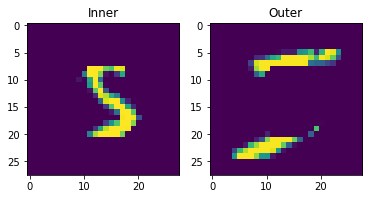

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
def mnist_cropper(x_data, outer):
    x_data = x_data.copy()
    coords = np.array(np.meshgrid(np.arange(0, 28), np.arange(0, 28)))
    in_center = np.sqrt(np.array((coords[0] - 14)**2 + (coords[1] - 14)**2)) < 7
    not_in_center = (1 - in_center).astype(np.bool)
    if outer:
        # zero the center
        x_data[:, in_center] = 0
    else:
        # zero the outsize
        x_data[:, not_in_center] = 0
    return x_data

In [ ]:
x_train_outer = mnist_cropper(x_train, True)
x_test_outer = mnist_cropper(x_test, True)
x_train_inner = mnist_cropper(x_train, False)
x_test_inner = mnist_cropper(x_test, False)

x_train_new = np.stack([x_train_inner, x_train_outer], axis=1)
x_test_new = np.stack([x_test_inner, x_test_outer], axis=1)

In [ ]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
x_train_new.shape

(60000, 2, 28, 28, 1)

Text(0.5, 1.0, 'Outer')

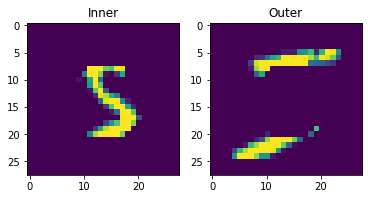

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(x_train_inner[0,:,:,0])
axs[0].set_title("Inner")
axs[1].imshow(x_train_outer[0,:,:,0])
axs[1].set_title("Outer")

### Model setup
We will first define a "toy" model for out task, which is just a very simple CNN (taken from [Simple MNIST convnet
](https://keras.io/examples/vision/mnist_convnet/))

In [ ]:
def gen_model(prepending_layer):
    if prepending_layer is None:
        model = model = keras.Sequential(
            [
                keras.Input(shape=(28, 28, 1)),
                layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Flatten(),
                layers.Dense(10, activation="softmax")
            ]
        )
    else:
        model = keras.Sequential(
            [
                keras.Input(shape=(2, 28, 28, 1)),
                prepending_layer,
                layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Flatten(),
                layers.Dense(10, activation="softmax")
            ]
        )
    return model

### Simulated Annealing

Since this is the same situtation as our prior example, we will use a simple exponentially scheduling of $\phi$, naively using a $\phi = 1.2$. We can use a custom layer to represent the application of our "discretization" layer

In [ ]:
import tensorflow as tf

class AnnealingLayer(layers.Layer):

    def __init__(self, psi):
        super(AnnealingLayer, self).__init__()
        self.psi = tf.Variable(initial_value=psi, trainable=False, dtype='float32')
        self.choice = tf.Variable(initial_value=0.0, trainable=True, dtype='float32')
        self.t = tf.Variable(initial_value=0.0, trainable=False, dtype='float32', name='timestep')        

    @tf.function
    def get_choice(self):
        scaling = tf.math.pow(self.psi, self.t)
        noise = tf.random.normal([1], stddev=0.1)
        choice = tf.nn.sigmoid(scaling*(self.choice + noise))
        return choice

    @tf.function
    def call(self, inputs):
        choice = self.get_choice()
        # mixing, assume shape of [B, K, H, W, C], where K is choice dimension
        outputs = inputs[:,0]*choice + (1 - choice)*inputs[:,1]
        return outputs



In [ ]:
annealing = AnnealingLayer(1.2)
model = gen_model(annealing)
batch_size = 128
epochs = 30

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
tf.nn.sigmoid(-0.0819183 * 1.2**38)

<tf.Tensor: shape=(), dtype=float32, numpy=4.8730013e-37>

In [ ]:
# now we can fit
for e in range(epochs):
    print(f"t = {model.weights[2]}")
    print(f"Choice = {model.layers[0].choice.numpy()}")
    print(f"Scaled choice = {model.layers[0].get_choice().numpy()}")
    model.fit(x_train_new, y_train, batch_size=batch_size, epochs=1, validation_split=0.1)
    weights = model.get_weights()
    # increment t
    weights[2] = weights[2] + 1
    model.set_weights(weights)

t = <tf.Variable 'timestep:0' shape=() dtype=float32, numpy=0.0>
Choice = 0.0
Scaled choice = [0.54501253]
422/422 [==============================] - 3s 6ms/step - loss: 0.7532 - accuracy: 0.7877 - val_loss: 0.1025 - val_accuracy: 0.9703
t = <tf.Variable 'timestep:0' shape=() dtype=float32, numpy=1.0>
Choice = -0.0281045101583004
Scaled choice = [0.47509372]
422/422 [==============================] - 2s 5ms/step - loss: 0.0887 - accuracy: 0.9734 - val_loss: 0.0714 - val_accuracy: 0.9798
t = <tf.Variable 'timestep:0' shape=() dtype=float32, numpy=2.0>
Choice = -0.0634429082274437
Scaled choice = [0.5040678]
422/422 [==============================] - 2s 5ms/step - loss: 0.0659 - accuracy: 0.9798 - val_loss: 0.0557 - val_accuracy: 0.9845
t = <tf.Variable 'timestep:0' shape=() dtype=float32, numpy=3.0>
Choice = -0.0733247920870781
Scaled choice = [0.4771805]
422/422 [==============================] - 2s 5ms/step - loss: 0.0564 - accuracy: 0.9828 - val_loss: 0.0487 - val_accuracy: 0.9857
t 

### Probabalistic Optimization

We will now do the same task, but using our other approach. First off we will use the continous version of the catergorical distribution and gradually raise the temperature following an exponential scaling

In [ ]:
import tensorflow_probability as tfp

class ProbsLayer(layers.Layer):


    def __init__(self):
        super(ProbsLayer, self).__init__()
        self.probs = tf.Variable(initial_value=0.0, trainable=True, dtype='float32')

    @tf.function
    def get_temp(self):
        temperature = 0.5
        dist = tfp.distributions.RelaxedBernoulli(temperature, logits=self.probs*10)
        choice = dist.sample()
        return choice

    @tf.function
    def call(self, inputs):
        choice = self.get_temp()
        # mixing, assume shape of [B, K, H, W, C], where K is choice dimension
        outputs = inputs[:,0]*choice + (1 - choice)*inputs[:,1]
        return outputs

In [ ]:
probs = ProbsLayer()
model = gen_model(probs)
batch_size = 128
epochs = 30

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# now we can fit
for e in range(epochs):
    print(f"Probs = {tf.nn.sigmoid(model.layers[0].probs.numpy()*10)}")
    print(f"Scaled choice = {model.layers[0].get_temp().numpy()}")
    model.fit(x_train_new, y_train, batch_size=batch_size, epochs=1, validation_split=0.1)

Probs = 0.515671546769393
Scaled choice = 0.0911383256316185
422/422 [==============================] - 3s 6ms/step - loss: 0.2323 - accuracy: 0.9277 - val_loss: 0.1860 - val_accuracy: 0.9405
Probs = 0.5799742974455835
Scaled choice = 0.0025955699384212494
422/422 [==============================] - 2s 6ms/step - loss: 0.1778 - accuracy: 0.9455 - val_loss: 0.1382 - val_accuracy: 0.9573
Probs = 0.6393638980583016
Scaled choice = 0.8954583406448364
422/422 [==============================] - 2s 6ms/step - loss: 0.1588 - accuracy: 0.9506 - val_loss: 0.1320 - val_accuracy: 0.9600
Probs = 0.602719193457155
Scaled choice = 0.1854415237903595
422/422 [==============================] - 2s 5ms/step - loss: 0.1416 - accuracy: 0.9556 - val_loss: 0.1105 - val_accuracy: 0.9673
Probs = 0.6490848725647822
Scaled choice = 0.29617616534233093
422/422 [==============================] - 2s 6ms/step - loss: 0.1226 - accuracy: 0.9611 - val_loss: 0.0907 - val_accuracy: 0.9720
Probs = 0.64411908577126
Scaled c

### Probabalistic Optimization with Approximation


In [ ]:
import tensorflow_probability as tfp

class ProbsApproxLayer(layers.Layer):
    def __init__(self):
        super(ProbsApproxLayer, self).__init__()
        self.probs = tf.Variable(initial_value=0.0, trainable=True, dtype='float32')

    @tf.function
    def get_temp(self):
        temperature = 1.0
        dist = tfp.distributions.RelaxedBernoulli(temperature, logits=self.probs*10)
        soft_choice = dist.sample()
        hard_choice = tf.round(soft_choice)
        choice = tf.stop_gradient(hard_choice - soft_choice) + soft_choice
        return choice

    @tf.function
    def call(self, inputs):
        choice = self.get_temp()
        # mixing, assume shape of [B, K, H, W, C], where K is choice dimension
        outputs = inputs[:,0]*choice + (1 - choice)*inputs[:,1]
        return outputs

In [ ]:
probsApprox = ProbsApproxLayer()
model = gen_model(probsApprox)
batch_size = 128
epochs = 30

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# now we can fit
for e in range(epochs):
    print(f"Probs = {tf.nn.sigmoid(model.layers[0].probs.numpy()*10)}")
    print(f"Scaled choice = {model.layers[0].get_temp().numpy()}")
    model.fit(x_train_new, y_train, batch_size=batch_size, epochs=1, validation_split=0.1)

Probs = 0.5
Scaled choice = 0.0
422/422 [==============================] - 3s 6ms/step - loss: 1.0437 - accuracy: 0.6649 - val_loss: 0.2521 - val_accuracy: 0.9228
Probs = 0.7484901244550256
Scaled choice = 1.0
422/422 [==============================] - 2s 6ms/step - loss: 0.2611 - accuracy: 0.9195 - val_loss: 0.2042 - val_accuracy: 0.9377
Probs = 0.8096545381737178
Scaled choice = 1.0
422/422 [==============================] - 2s 5ms/step - loss: 0.2176 - accuracy: 0.9318 - val_loss: 0.1697 - val_accuracy: 0.9495
Probs = 0.8425191017557389
Scaled choice = 1.0
422/422 [==============================] - 2s 5ms/step - loss: 0.1920 - accuracy: 0.9392 - val_loss: 0.1734 - val_accuracy: 0.9485
Probs = 0.8782779546473841
Scaled choice = 1.0
422/422 [==============================] - 2s 6ms/step - loss: 0.1733 - accuracy: 0.9459 - val_loss: 0.1352 - val_accuracy: 0.9592
Probs = 0.8999903632982252
Scaled choice = 1.0
422/422 [==============================] - 2s 6ms/step - loss: 0.1569 - accura

### Validation

Since all three of our methods converged

In [ ]:
model_inner = gen_model(None)
batch_size = 128
epochs = 30
model_inner.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_inner.fit(x_train_inner, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/30
422/422 [==============================] - 3s 6ms/step - loss: 0.8928 - accuracy: 0.7403 - val_loss: 0.1990 - val_accuracy: 0.9433
Epoch 2/30
422/422 [==============================] - 2s 5ms/step - loss: 0.2275 - accuracy: 0.9317 - val_loss: 0.1568 - val_accuracy: 0.9532
Epoch 3/30
422/422 [==============================] - 2s 5ms/step - loss: 0.1815 - accuracy: 0.9447 - val_loss: 0.1341 - val_accuracy: 0.9615
Epoch 4/30
422/422 [==============================] - 2s 5ms/step - loss: 0.1609 - accuracy: 0.9508 - val_loss: 0.1256 - val_accuracy: 0.9630
Epoch 5/30
422/422 [==============================] - 2s 5ms/step - loss: 0.1494 - accuracy: 0.9544 - val_loss: 0.1132 - val_accuracy: 0.9648
Epoch 6/30
422/422 [==============================] - 2s 5ms/step - loss: 0.1380 - accuracy: 0.9560 - val_loss: 0.1167 - val_accuracy: 0.9627
Epoch 7/30
422/422 [==============================] - 2s 5ms/step - loss: 0.1253 - accuracy: 0.9602 - val_loss: 0.1090 - val_accuracy: 0.9658
Epoch 

In [ ]:
model_outer = gen_model(None)
batch_size = 128
epochs = 30
model_outer.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_outer.fit(x_train_outer, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/30
422/422 [==============================] - 3s 5ms/step - loss: 0.9401 - accuracy: 0.6965 - val_loss: 0.2600 - val_accuracy: 0.9175
Epoch 2/30
422/422 [==============================] - 2s 5ms/step - loss: 0.2917 - accuracy: 0.9065 - val_loss: 0.2007 - val_accuracy: 0.9407
Epoch 3/30
422/422 [==============================] - 2s 5ms/step - loss: 0.2337 - accuracy: 0.9243 - val_loss: 0.1941 - val_accuracy: 0.9382
Epoch 4/30
422/422 [==============================] - 2s 5ms/step - loss: 0.2067 - accuracy: 0.9338 - val_loss: 0.1753 - val_accuracy: 0.9447
Epoch 5/30
422/422 [==============================] - 2s 5ms/step - loss: 0.1937 - accuracy: 0.9371 - val_loss: 0.1754 - val_accuracy: 0.9430
Epoch 6/30
422/422 [==============================] - 2s 5ms/step - loss: 0.1839 - accuracy: 0.9392 - val_loss: 0.1638 - val_accuracy: 0.9462
Epoch 7/30
422/422 [==============================] - 2s 5ms/step - loss: 0.1734 - accuracy: 0.9436 - val_loss: 0.1617 - val_accuracy: 0.9468
Epoch 

# Exercise: Categorical Selection From a Set

We are now going to build up to selecting $k$ from a set of $N$, where $k < N$. For sake of brevity we will focus on the probabalistic approach, if you are interested in the annealing approach please contact me after lab (or we can simply discuss it after lab).

In a probabalistic framework we will use an N-way categorical distribution, this means a distribution with N independent outcomes. Naturally, this N-way distribution requires a probability vector of $P = [p_1, p_2, \dots p_N]$.

**However**, instead of raw probabilities we typically use *logits*. Such that $P = softmax(L)$. This allows our logit values to be unrestricted (i.e. take on any value).

## Part 1a: Create an N-way categorical distribution and sample from it

In [1]:
import numpy as np
from scipy.special import softmax
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

N = 5
# create some logits vector of length N
logits = np.array([1, 2, -3., 4, 0])
# create the probs version of logits: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.softmax.html
probs = softmax(logits)
# create your distribution: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical
dist = tfp.distributions.Categorical(logits)
# sample your distribution 100 times
samples = dist.sample(100)

# create a bar plot of your samples, do they make sense with your logits?

(array([ 3.,  8.,  0., 86.,  3.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <a list of 5 Patch objects>)

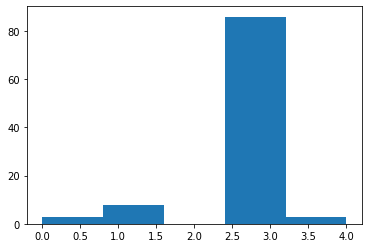

In [2]:
plt.hist(samples, bins=N)

## Part 1b: Relaxed N-Way categorical distribution

 Now lets replace the standard categorical distribution with a relaxed one. Assign a temperature of $1.0$. See: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/RelaxedOneHotCategorical

In [3]:
import numpy as np
from scipy.special import softmax
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

N = 5
temp = 1.0
# create some logits vector of length N
logits = np.array([1, 2, -3., 4, 0])
# create the probs version of logits: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.softmax.html
probs = softmax(logits)
# create your distribution: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical
dist = tfp.distributions.RelaxedOneHotCategorical(temp, logits=logits)
# sample your distribution 100 times
samples = dist.sample(100)
# create a bar plot of your samples, do they make sense with your logits?

<BarContainer object of 5 artists>

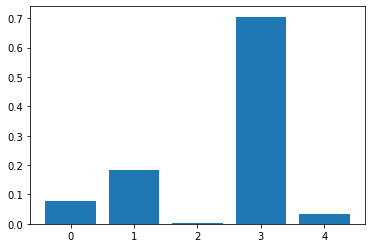

In [14]:
plt.bar(np.arange(0, 5), np.mean(samples, axis=0))

## Part 1c: Mixing with samples

In [15]:
# grab the first sample
sample = samples[0]

In [16]:
# we will now create a dummy dataset
dataset = np.ones([1, N, 28, 28])
for i in range(N):
    dataset[:,i] = i

In [73]:
import tensorflow as tf
# now create a "sampled" dataset
discretized_dataset = tf.math.reduce_sum(dataset * tf.reshape(sample, (1,5,1,1)), axis=1)

## Part 2: Creating a test dataset

We are going to create another MNIST derivative, except this time we are going to make N different versions. We will let $N=3$, similar to the previous example we will spatially divide the image into three parts

In [4]:
def split_mnist(x_data, split):
    x_data = x_data.copy()
    coords = np.array(np.meshgrid(np.arange(0, 28), np.arange(0, 28)))
    # inner radius 4 of pixels
    split_0 = np.sqrt(np.array((coords[0] - 14)**2 + (coords[1] - 14)**2)) <= 4
    # inner radius 8 of pixels
    split_1 = np.sqrt(np.array((coords[0] - 14)**2 + (coords[1] - 14)**2)) <= 7
    if split == 0:
        mask = (1 - split_0).astype(np.bool)
    elif split == 1:
        # inside 4 or outside 7
        mask = np.bitwise_or(split_0, (1 - split_1).astype(np.bool)).astype(np.bool)
    else:
        # inside 7
        mask = split_1.astype(np.bool)
    x_data[:, mask] = 0
    return x_data

In [5]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
# using the above function create new training datasets and test datasets, 
x_train_splits = np.stack([split_mnist(x_train, split) for split in range(3)], axis=1)
x_test_splits = np.stack([split_mnist(x_test, split) for split in range(3)], axis=1)

11493376/11490434 [==============================] - 0s 0us/step


## Part 3a: Encoding in a Layer

Following my previous example, create a layer which uses the relaxed categorical distribution


In [6]:
import tensorflow as tf
class ProbsApproxCatLayer(layers.Layer):
    def __init__(self, N):
        super(ProbsApproxCatLayer, self).__init__()
        self.N = N
        initializer = tf.random_normal_initializer()
        # create initial values based on N
        self.logits = tf.Variable(initial_value=initializer([self.N]), trainable=True, dtype='float32')

    @tf.function
    def get_temp(self):
        dist = tfp.distributions.RelaxedOneHotCategorical(1.0, self.logits)
        soft_choice = dist.sample()
        # bit more complicated, using the identity trick
        hard_choice = tf.eye(self.N)[tf.argmax(soft_choice)]
        choice = tf.stop_gradient(hard_choice - soft_choice) + soft_choice
        return choice

    @tf.function
    def call(self, inputs):
        choice = self.get_temp()
        # mixing, assume shape of [B, K, H, W, C], where K is choice dimension
        # choice is now of shape [K], what shape should it be broadcast to for the next expression to work?
        # hint you've already done this!
        outputs = tf.math.reduce_sum(inputs*tf.reshape(choice, (1, self.N, 1, 1, 1)), axis=1)
        return outputs

In [7]:
def create_model(encoding_layer=None, N=3):
    if encoding_layer is None:
        model = model = keras.Sequential(
            [
                keras.Input(shape=(28, 28, 1)),
                layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Flatten(),
                layers.Dense(10, activation="softmax")
            ]
        )
    else:
        model = keras.Sequential(
            [
                keras.Input(shape=(N, 28, 28, 1)),
                encoding_layer,
                layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Flatten(),
                layers.Dense(10, activation="softmax")
            ]
        )
    return model

## Part 3b: Train your model

In [8]:
probs = ProbsApproxCatLayer(3)
model = create_model(probs, 3)
batch_size = 128
epochs = 30
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [10]:
model.fit(x_train_splits, y=y_train, epochs=10,batch_size=batch_size)

Epoch 1/10
469/469 [==============================] - 6s 11ms/step - loss: 0.1999 - accuracy: 0.9352
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1897 - accuracy: 0.9389
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1882 - accuracy: 0.9395
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1699 - accuracy: 0.9454
Epoch 5/10
469/469 [==============================] - 5s 11ms/step - loss: 0.1740 - accuracy: 0.9452
Epoch 6/10
469/469 [==============================] - 5s 11ms/step - loss: 0.1640 - accuracy: 0.9476
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1564 - accuracy: 0.9503
Epoch 8/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1450 - accuracy: 0.9532
Epoch 9/10
469/469 [==============================] - 5s 11ms/step - loss: 0.1418 - accuracy: 0.9539
Epoch 10/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1433 - accura

In [69]:
model.weights[0]

<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([-1.8270918,  2.6603873, -1.8582532], dtype=float32)>

## Part 3c: Validate your models preference

You model has convereged to some preferrred way of sampling (split 0, split 1, or split 2). Test all three splits **independently** and see which one is the best. Note, we can only due this because MNIST is trivial.

In [11]:
for split in range(3):
    x_data = x_train_splits[:,split]
    model = create_model(None, 3)
    batch_size = 128
    epochs = 30
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_data, y=y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 1.1181 - accuracy: 0.6157
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6504 - accuracy: 0.7805
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5832 - accuracy: 0.8026
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5508 - accuracy: 0.8114
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5226 - accuracy: 0.8220
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5148 - accuracy: 0.8252
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4912 - accuracy: 0.8323
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4866 - accuracy: 0.8366
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4672 - accuracy: 0.8423
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4

## Part 4a: Extending to multiple samples

Now that we have done sampling for a single sample, lets do it for two. This is actually much easier than you may think. Instead of sampling once, we now simply sample twice. The only difference between the two samples is that they use different logits.

If you are confident you can jump straight to training a model to do this encoding, if not I suggest you build it up like we did in Part 1

In [12]:
import tensorflow as tf
class ProbsApproxCatMultiLayer(layers.Layer):
    def __init__(self, N):
        super(ProbsApproxCatMultiLayer, self).__init__()
        self.N = N
        initializer = tf.random_normal_initializer()
        # create initial values based on N
        self.logits = tf.Variable(initial_value=initializer([self.N, 2]), trainable=True, dtype='float32')

    @tf.function
    def get_temp(self):
        dist_1 = tfp.distributions.RelaxedOneHotCategorical(1.0, self.logits[:,0])
        dist_2 = tfp.distributions.RelaxedOneHotCategorical(1.0, self.logits[:,1])
        soft_choice_1 = dist_1.sample()
        soft_choice_2 = dist_2.sample()
        # bit more complicated, using the identity trick
        hard_choice_1 = tf.eye(self.N)[tf.argmax(soft_choice_1)]
        hard_choice_2 = tf.eye(self.N)[tf.argmax(soft_choice_2)]
        choice_1 = tf.stop_gradient(hard_choice_1 - soft_choice_1) + soft_choice_2
        choice_2 = tf.stop_gradient(hard_choice_2 - soft_choice_2) + soft_choice_2
        return (choice_1 + choice_2)

    @tf.function
    def call(self, inputs):
        choice = self.get_temp()
        # mixing, assume shape of [B, K, H, W, C], where K is choice dimension
        # choice is now of shape [K], what shape should it be broadcast to for the next expression to work?
        # hint you've already done this!
        outputs = tf.math.reduce_sum(inputs*tf.reshape(choice, (1, self.N, 1, 1, 1)), axis=1)
        return outputs

## Part 4b: Train your model

In [19]:
probs = ProbsApproxCatMultiLayer(3)
model = create_model(probs, 3)
batch_size = 128
epochs = 30
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [20]:
model.fit(x_train_splits, y=y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.7484 - accuracy: 0.7681
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2061 - accuracy: 0.9366
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1498 - accuracy: 0.9536
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1375 - accuracy: 0.9575
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1193 - accuracy: 0.9639
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1116 - accuracy: 0.9643
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1047 - accuracy: 0.9671
Epoch 8/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0928 - accuracy: 0.9715
Epoch 9/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0959 - accuracy: 0.9706
Epoch 10/10
1875/1875 [==============================] - 13s 7ms/step - l

In [21]:
model.weights[0]

<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.01484014, -0.8734552 ],
       [ 0.00800795,  0.44689474],
       [ 0.03244628,  0.33149126]], dtype=float32)>

## Part 4c: Validate your models choice
Since you have three options and need to choose to you have the following possible combinations:
- Split 0 & Split 1
- Split 0 & Split 2
- Split 1 & Split 2

Try all of them, does the top performing configuration match your models configuration?

In [18]:
splits = [[0, 1], [0, 2], [1,2]]
for split in splits:
    probs = ProbsApproxCatMultiLayer(3)
    model = create_model(None, 3)
    batch_size = 128
    epochs = 30
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    x_data = (x_train_splits[:,split[0]] + x_train_splits[:,split[1]])/2
    model.fit(x_data, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6149 - accuracy: 0.8043
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1747 - accuracy: 0.9459
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1389 - accuracy: 0.9572
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1235 - accuracy: 0.9620
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1060 - accuracy: 0.9662
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0929 - accuracy: 0.9705
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0842 - accuracy: 0.9725
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0806 - accuracy: 0.9744
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0735 - accuracy: 0.9759
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0

In [17]:
x_data.shape

(3, 28, 28, 1)